<a href="https://colab.research.google.com/github/shoham529-byte/1-repo/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/titanic.csv")
print(f"Dataset shape: {df.shape}")
df.sample(5)

Dataset shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
677,678,1,3,"Turja, Miss. Anna Sofia",female,18.0,0,0,4138,9.8417,NaN,S
817,818,0,2,"Mallet, Mr. Albert",male,31.0,1,1,S.C./PARIS 2079,37.0042,NaN,C
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S
275,276,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0,1,0,13502,77.9583,D7,S


In [7]:
print("Null values per column:")
print("\nPercentage of null values:")
print((df.isnull().sum() / len(df)) * 100)

Null values per column:

Percentage of null values:
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [8]:
print("Statistical Summary:")
df.describe()

Statistical Summary:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
duplicated_count = df.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")
if duplicated_count > 0:
    print("\nDuplicated rows:")
    print(df[df.duplicated()])
else:
    print("No duplicated rows found!")


Number of duplicated rows: 0
No duplicated rows found!


In [10]:
print("Unique values in categorical columns:")

categorical_cols = ['Sex', 'Embarked']

for col in categorical_cols:
    if col in df.columns:
        unique_vals = df[col].unique()
        value_counts = df[col].value_counts().sort_index()
        print(f"\n{col}:")
        print(f"  Unique values: {unique_vals}")
        print(f"  Count of each value:")
        for val, count in value_counts.items():
            print(f"    {val}: {count} ({count/len(df)*100:.1f}%)")
        print(f"  Null values: {df[col].isnull().sum()}")

Unique values in categorical columns:

Sex:
  Unique values: ['male' 'female']
  Count of each value:
    female: 314 (35.2%)
    male: 577 (64.8%)
  Null values: 0

Embarked:
  Unique values: ['S' 'C' 'Q' nan]
  Count of each value:
    C: 168 (18.9%)
    Q: 77 (8.6%)
    S: 644 (72.3%)
  Null values: 2


In [11]:
df_encoded = df.copy()

In [12]:
df_encoded['Sex'] = df_encoded['Sex'].map({'male': -1, 'female': 1})
print("Sex encoded using Label Encoding")
print("  male → 0, female → 1")
print(f"  Encoded values: {df_encoded['Sex'].unique()}")

Sex encoded using Label Encoding
  male → 0, female → 1
  Encoded values: [-1  1]


In [13]:
df_encoded['Embarked'] = df_encoded['Embarked'].fillna('S')

# Create one-hot encoding (k-1: drop one column to avoid multicollinearity)
embarked_dummies = pd.get_dummies(df_encoded['Embarked'], prefix='Embarked', drop_first=True)

# Add to dataframe and drop original
df_encoded = pd.concat([df_encoded, embarked_dummies], axis=1)
df_encoded = df_encoded.drop('Embarked', axis=1)

print("Embarked encoded using K-1 one-hot encoding")
print(f"New columns: {list(embarked_dummies.columns)}")

Embarked encoded using K-1 one-hot encoding
New columns: ['Embarked_Q', 'Embarked_S']


In [14]:
df['Sex'] = df_encoded['Sex'].values

# Copy Embarked encoding (one-hot columns) - convert to int first
embarked_cols = [col for col in df_encoded.columns if 'Embarked' in col]
for col in embarked_cols:
    df[col] = df_encoded[col].astype(int).values

In [15]:
if 'Embarked' in df.columns:
    df = df.drop('Embarked', axis=1)

print("Updated original dataframe (df) with encoded values")
print(f"df shape: {df.shape}")
print(f"df columns: {list(df.columns)}")

Updated original dataframe (df) with encoded values
df shape: (891, 13)
df columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked_Q', 'Embarked_S']


In [16]:
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare']
#cabin-many nulls
#fare-highly correlated with pclass
#ticket-mostly unique identifiers
#name-text data
#passengerid-unique identifier

# Only drop columns that exist
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

print(f"Dropping columns: {columns_to_drop}")
df = df.drop(columns=columns_to_drop)

print(f"\nNew shape: {df.shape}")
print(f"Remaining columns: {list(df.columns)}")
print("\nSample of cleaned data:")
df.sample(5)

Dropping columns: ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare']

New shape: (891, 8)
Remaining columns: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked_Q', 'Embarked_S']

Sample of cleaned data:


,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked_Q,Embarked_S
836,0,3,-1,21.0,0,0,0,1
387,1,2,1,36.0,0,0,0,1
400,1,3,-1,39.0,0,0,0,1
832,0,3,-1,NaN,0,0,0,0
433,0,3,-1,17.0,0,0,0,1


In [17]:
df['Age'] = df['Age'].fillna(df['Age'].median())

# Separate features (X) and target (y)
X = df.drop('Survived', axis=1)
y = df['Survived']

# Convert to numpy arrays
X = X.values
y = y.values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeatures: {list(df.drop('Survived', axis=1).columns)}")
print(f"\nMissing values in X: {np.isnan(X).sum()}")
print(f"Missing values in y: {np.isnan(y).sum()}")


X shape: (891, 7)
y shape: (891,)

Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked_Q', 'Embarked_S']

Missing values in X: 0
Missing values in y: 0


In [18]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    n = len(X)
    indices = np.arange(n)
    np.random.shuffle(indices)

    split_idx = int(n * (1 - test_size))

    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]

    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]

    return X_train, X_test, y_train, y_test

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train-Test Split Complete!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Train-Test Split Complete!
Training set: 712 samples
Test set: 179 samples
Train features shape: (712, 7)
Test features shape: (179, 7)


In [19]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only continuous features (Age, SibSp, Parch)
scale_indices = [2, 3, 4]  # Age, SibSp, Parch

for idx in scale_indices:
    mean = np.mean(X_train[:, idx])
    std = np.std(X_train[:, idx])

    if std == 0:
        std = 1

    X_train_scaled[:, idx] = (X_train[:, idx] - mean) / std
    X_test_scaled[:, idx] = (X_test[:, idx] - mean) / std

print("Feature Scaling Complete!")
print("Scaled features: Age, SibSp, Parch")
print("Unscaled features: Pclass, Sex, Embarked_Q, Embarked_S")
print(f"\nScaled training data stats (Age, SibSp, Parch):")
print(f"  Mean: {np.mean(X_train_scaled[:, scale_indices], axis=0)}")
print(f"  Std: {np.std(X_train_scaled[:, scale_indices], axis=0)}")

Feature Scaling Complete!
Scaled features: Age, SibSp, Parch
Unscaled features: Pclass, Sex, Embarked_Q, Embarked_S

Scaled training data stats (Age, SibSp, Parch):
  Mean: [ 1.54682758e-16 -9.97953281e-18  1.99590656e-17]
  Std: [1. 1. 1.]


In [20]:
class SVM:
    def __init__(self, C=1.0, tol=1e-3, max_passes=5, kernel='linear'):
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.kernel = kernel
        self.alpha = None
        self.b = 0
        self.w = None
        self.X = None
        self.y = None
        self.K = None

    def fit(self, X, y):
        n, d = X.shape
        self.X = X
        self.y = y
        self.alpha = np.zeros(n)
        self.b = 0

        # Precompute linear kernel matrix
        self.K = np.dot(X, X.T)

        passes = 0

        print(f"Training SVM with C={self.C}...")

        while passes < self.max_passes:
            alpha_changed = 0

            for i in range(n):
                # Calculate error for example i
                Ei = self._decision_train(i) - y[i]

                # Check KKT violation
                if ((y[i]*Ei < -self.tol and self.alpha[i] < self.C) or
                    (y[i]*Ei > self.tol and self.alpha[i] > 0)):

                    # Select random j != i
                    j = np.random.choice([k for k in range(n) if k != i])
                    Ej = self._decision_train(j) - y[j]

                    # Save old alphas
                    ai_old = self.alpha[i]
                    aj_old = self.alpha[j]

                    # Compute L and H bounds
                    if y[i] != y[j]:
                        L = max(0, aj_old - ai_old)
                        H = min(self.C, self.C + aj_old - ai_old)
                    else:
                        L = max(0, ai_old + aj_old - self.C)
                        H = min(self.C, ai_old + aj_old)

                    if L == H:
                        continue

                    # Compute eta
                    eta = 2*self.K[i,j] - self.K[i,i] - self.K[j,j]
                    if eta >= 0:
                        continue

                    # Update alpha_j
                    self.alpha[j] -= y[j] * (Ei - Ej) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)

                    if abs(self.alpha[j] - aj_old) < 1e-5:
                        continue

                    # Update alpha_i
                    self.alpha[i] += y[i] * y[j] * (aj_old - self.alpha[j])

                    # Compute b1 and b2
                    b1 = self.b - Ei \
                         - y[i]*(self.alpha[i]-ai_old)*self.K[i,i] \
                         - y[j]*(self.alpha[j]-aj_old)*self.K[i,j]

                    b2 = self.b - Ej \
                         - y[i]*(self.alpha[i]-ai_old)*self.K[i,j] \
                         - y[j]*(self.alpha[j]-aj_old)*self.K[j,j]

                    # Update b
                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    alpha_changed += 1

            if alpha_changed == 0:
                passes += 1
            else:
                passes = 0

            if passes == 0 and alpha_changed > 0:
                print(f"  Pass: {alpha_changed} alphas changed")

        # Compute weight vector w after training
        self.w = np.sum((self.alpha * y)[:, None] * X, axis=0)

        # Count support vectors
        sv_count = np.sum(self.alpha > 1e-5)
        print(f"Training complete! Support vectors: {sv_count}/{n}")

    def _decision_train(self, i):
        """Decision function using dual form during training"""
        return np.sum(self.alpha * self.y * self.K[:, i]) + self.b

    def predict(self, X):

        decision = np.dot(X, self.w) + self.b
        return np.sign(decision)

In [21]:
svm = SVM(C=0.01, tol=1e-3, max_passes=5)
svm.fit(X_train_scaled, y_train)
# Predict
y_pred = svm.predict(X_test_scaled)

# Accuracy
acc = np.mean(y_pred == y_test)
print("Accuracy:", acc)

Training SVM with C=0.01...
Training complete! Support vectors: 0/712
Accuracy: 0.6368715083798883


In [22]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_feature_importance(weights, feature_names):
    plt.figure(figsize=(10, 6))
    indices = np.argsort(np.abs(weights))[::-1]
    plt.title("Feature Importance (SVM Weights)")
    plt.bar(range(len(weights)), np.abs(weights[indices]), align="center")
    plt.xticks(range(len(weights)), np.array(feature_names)[indices], rotation=45)
    plt.xlim([-1, len(weights)])
    plt.tight_layout()
    plt.show()

def plot_decision_boundary_2d(X, y, model_template, feature_indices, feature_names):
    X_subset = X[:, feature_indices]
    # Train new model on subset
    print(f"Training temporary 2D model for {feature_names[feature_indices[0]]} vs {feature_names[feature_indices[1]]}...")
    new_model = SVM(C=model_template.C, tol=model_template.tol, max_passes=model_template.max_passes)
    new_model.fit(X_subset, y)

    # Grid
    h = .02
    x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
    y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = new_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_subset[:, 0], X_subset[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=20)
    plt.xlabel(feature_names[feature_indices[0]])
    plt.ylabel(feature_names[feature_indices[1]])
    plt.title(f'SVM Decision Boundary ({feature_names[feature_indices[0]]} vs {feature_names[feature_indices[1]]})')
    plt.show()

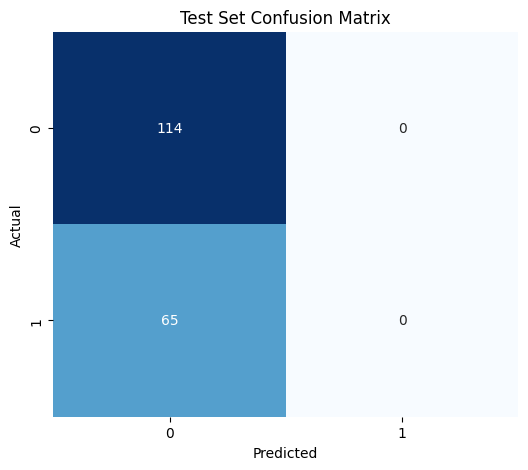

In [23]:
plot_confusion_matrix(y_test, y_pred, 'Test Set Confusion Matrix')